In [1]:
%load_ext autoreload
%autoreload 3

import pickle
import modules.measures as measures
import modules.data_preparation as data_prep
import modules.constants as const
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import modules.statistics as stat

In [2]:
ADAPT_TO_MIO_OBJECTIVES = True

Say we have a set of random walks for the same problem (same app, same objective, same fitness function)

# RQ1

In [3]:
# information_content_values.to_csv("store/information_content_measure_df.csv", index=False)

information_content_values = pd.read_csv("store2/information_content_measure_df_with_objectives.csv")

if ADAPT_TO_MIO_OBJECTIVES:
    information_content_values = pd.merge(information_content_values, data_prep.get_mio_runs()[const.OBJECTIVE].drop_duplicates(), on=const.OBJECTIVE)

In [4]:
if ADAPT_TO_MIO_OBJECTIVES:
    assert len(information_content_values.index) == 52000
else:
    assert len(information_content_values.index) == 104280

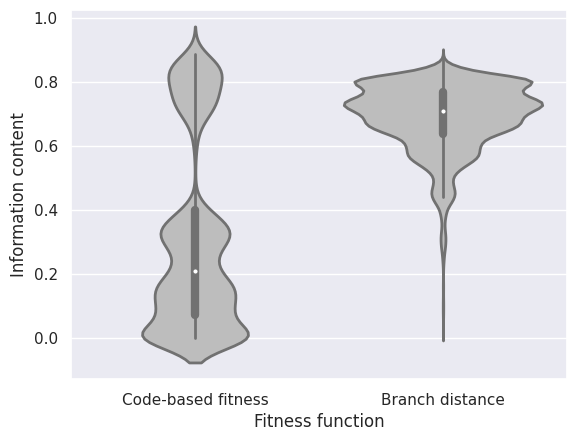

In [5]:
output_file = Path(const.DIAGRAM_OUT_PATH) / (const.INFORMATION_CONTENT + ".pdf")
sns.set_theme(style="darkgrid")

fig = plt.figure()
ax = sns.violinplot(data=information_content_values, x=const.FITNESS_FUNCTION, y=const.INFORMATION_CONTENT, linewidth=2, color="#bdbdbd", order=[const.CODE_BASED, const.BRANCH_DISTANCE])
plt.savefig(output_file)
plt.close(fig)
fig

# RQ2

First, we check if we have all 20 measure values for each objective and fitness function and if we have all two fitness function per objective

In [6]:
for index, row in information_content_values.groupby([const.FITNESS_FUNCTION, const.OBJECTIVE]).aggregate(lambda l: len(l)).iterrows():
    assert row[const.INFORMATION_CONTENT] == 20

we calculate the p-value and effect size for every objective and check if none of them is null

In [7]:
objectives = information_content_values['Objective'].drop_duplicates()
fitness_functions = [const.CODE_BASED, const.BRANCH_DISTANCE]

information_content_dict_ps = {}

for objective in objectives:
    branch_distance_list = information_content_values[(information_content_values[const.FITNESS_FUNCTION] == const.BRANCH_DISTANCE) & (information_content_values[const.OBJECTIVE] == objective)][const.INFORMATION_CONTENT]
    code_based_list = information_content_values[(information_content_values[const.FITNESS_FUNCTION] == const.CODE_BASED) & (information_content_values[const.OBJECTIVE] == objective)][const.INFORMATION_CONTENT]
    assert len(branch_distance_list) == 20
    assert len(code_based_list) == 20
    information_content_dict_ps[objective] = stat.calculate_mann_whitney_p_value(list(code_based_list), list(branch_distance_list))

now, we generate a list of all p-values

In [8]:
statistics_tuples = list(information_content_dict_ps.values())
p_values = [x[0] for x in statistics_tuples]

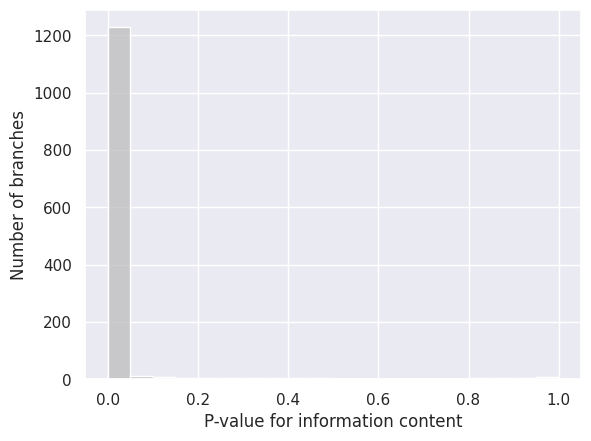

In [9]:
from matplotlib import pyplot as plt
import modules.constants as const
from pathlib import Path
import seaborn as sns

output_file = Path(const.DIAGRAM_OUT_PATH) / "information_content_p-values.pdf"

sns.set_theme(style="darkgrid")



fig = plt.figure()
sns.histplot(p_values, binwidth=0.05, color="#bdbdbd")
plt.xlabel("P-value for information content")
plt.ylabel("Number of branches")

plt.savefig(output_file)
plt.close(fig)

fig

significant: 1228
insignificant: 72


<Figure size 640x480 with 0 Axes>

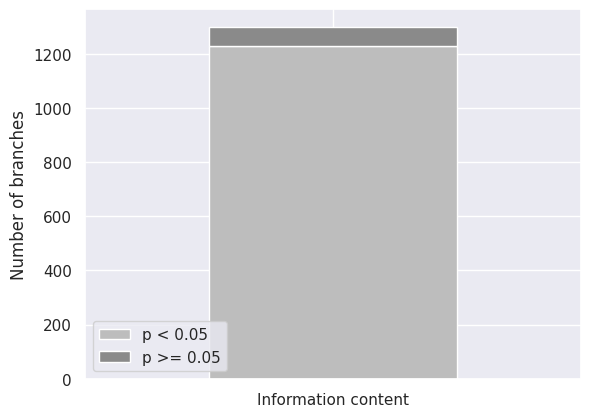

In [10]:
from pandas import DataFrame

p_values_significant = [x for x in p_values if x < 0.05]
p_values_insignificant = [x for x in p_values if x >= 0.05]

assert len(p_values) == len(p_values_significant) + len(p_values_insignificant)

fig = plt.figure()

number_significant = len(p_values_significant)
number_insignificant = len(p_values_insignificant)

barplot_data_dict = {"p < 0.05": [number_significant], "p >= 0.05": [number_insignificant]}
barplot_data_df = DataFrame(barplot_data_dict, index=["Information content"])

# sns.barplot(data=barplot_data_df, color="#bdbdbd")

barplot_data_df.plot(kind='bar', stacked=True, color=["#bdbdbd", '#8a8a8a', 'green'])
plt.ylabel("Number of branches")
plt.xticks(rotation=0)

plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "information_content_p-values_two-bins.pdf")
plt.close(fig)

print("significant: " + str(len(p_values_significant)))
print("insignificant: " + str(len(p_values_insignificant)))

fig

## Effect Sizes

In [11]:
effect_size_values = [x[1] for x in statistics_tuples]
effect_size_values_significant = [x[1] for x in statistics_tuples if x[0] < 0.05]
effect_size_values_insignificant = [x[1] for x in statistics_tuples if x[0] >= 0.05]
assert len(effect_size_values) == len(effect_size_values_significant) + len(effect_size_values_insignificant)

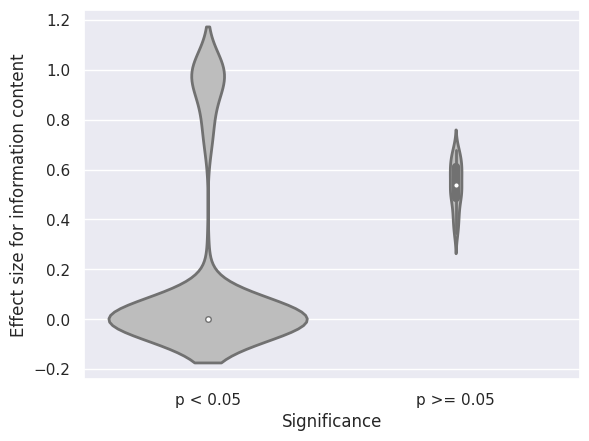

In [12]:
sns.set_theme(style="darkgrid")

x_axis = "Significance"
y_axis = "Effect size for information content"

list_of_tuples = []
for size in effect_size_values_significant:
    list_of_tuples.append(("p < 0.05", size))
for size in effect_size_values_insignificant:
    list_of_tuples.append(("p >= 0.05", size))

effect_sizes_df = DataFrame(list_of_tuples, columns=[x_axis, y_axis])

fig = plt.figure()
sns.violinplot(data=effect_sizes_df, x=x_axis, y=y_axis, linewidth=2, color="#bdbdbd", order=["p < 0.05", "p >= 0.05"], scale="count")
plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "information_content_effect_size.pdf")
plt.close(fig)
fig

In [13]:
effect_sizes_sig = effect_sizes_df.query("Significance=='p < 0.05'")
effect_sizes_sig_smaller = effect_sizes_sig.query("`Effect size for information content` < 0.5 and `Effect size for information content` >= @measures.machine_epsilon")
effect_sizes_sig_greater = effect_sizes_sig.query("`Effect size for information content` > 0.5")
effect_sizes_sig_zero = effect_sizes_sig.query("`Effect size for information content` < @measures.machine_epsilon")

number_zero = len(effect_sizes_sig_zero.index)
number_smaller = len(effect_sizes_sig_smaller.index)
number_greater = len(effect_sizes_sig_greater.index)

print(str(len(effect_sizes_sig.index)))
print(str(number_zero))
print(str(number_smaller))
print(str(number_greater))

assert len(effect_sizes_sig.index) == number_zero + number_smaller + number_greater

1228
974
30
224


<Figure size 640x480 with 0 Axes>

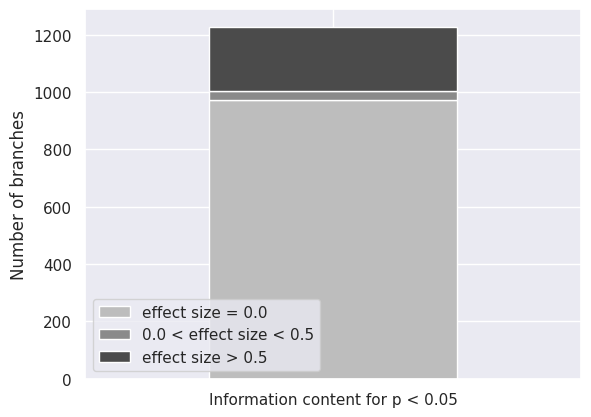

In [14]:
assert len(effect_sizes_sig.index) == number_zero + number_smaller + number_greater
from pandas import DataFrame

fig = plt.figure()

barplot_data_dict = {"effect size = 0.0": [number_zero], "0.0 < effect size < 0.5": [number_smaller], "effect size > 0.5": [number_greater]}
barplot_data_df = DataFrame(barplot_data_dict, index=["Information content for p < 0.05"])

# sns.barplot(data=barplot_data_df, color="#bdbdbd")

ax = barplot_data_df.plot(kind='bar', stacked=True, color=["#bdbdbd", '#8a8a8a', "#4b4b4b"])
sns.move_legend(ax, "lower left")
plt.ylabel("Number of branches")
plt.xticks(rotation=0)

plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "information_content_effect_size_two-bins.pdf")
plt.close(fig)

fig

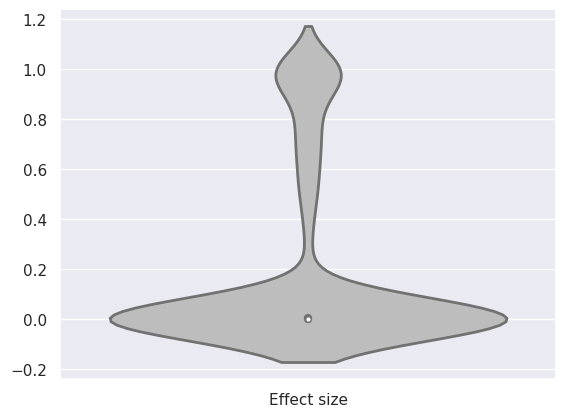

In [15]:
sns.set_theme(style="darkgrid")

effect_size_values_not_none_df = DataFrame(effect_size_values, columns=["Effect size"])

fig = plt.figure()
sns.violinplot(data=effect_size_values_not_none_df, linewidth=2, color="#bdbdbd")
plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "information_content_effect-size_aggregated.pdf")
plt.close(fig)
fig